# Ethan Ooi | Explore the Data

## Import Libraries

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load the CSV (betting spreads)
bets = pd.read_csv('nba_data/nba_betting_spread.csv')
# Create filtered betting spreads dataset
bets = bets[bets['book_name'] == 'BetOnline']
# Drop unnecessary columns
bets = bets.drop(columns=['book_name', 'book_id', 'price1', 'price2']).reset_index(drop=True)

# Load the CSV (all games)
games = pd.read_csv('nba_data/nba_games_all.csv')
# No betting data before 2007
games = games[games['season_year'] >= 2007]
# Drop unnecessary columns
games = games.drop(columns=['game_date', 'matchup', 'w', 'l', 'season_year', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 
                    'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'season'])

In [16]:
bets.head()

,game_id,team_id,a_team_id,spread1,spread2
0,21000358,1610612749,1610612742,7.5,-7.5
1,21000361,1610612755,1610612751,-1.5,1.5
2,21000362,1610612747,1610612764,-10.5,10.5
3,21000367,1610612747,1610612754,-3.5,3.5
4,21000372,1610612766,1610612763,8.5,-8.5


In [17]:
games.head()

,game_id,team_id,is_home,wl,w_pct,a_team_id,season_type
0,20800741,1610612762,f,W,0.569,1610612758,Regular Season
1,20800701,1610612762,f,L,0.542,1610612757,Regular Season
2,20800584,1610612762,f,W,0.600,1610612763,Regular Season
3,20800558,1610612762,t,W,0.605,1610612754,Regular Season
4,20800440,1610612762,f,L,0.563,1610612745,Regular Season


In [18]:
# Merge games & bets dataset on game_id
df = games.merge(bets[['game_id', 'spread1', 'spread2']], on='game_id', how='left')
# Filter the dataset to include only games where spread1 > 0, underdogs
# Drop duplicate game_ids and nulls
df = df[df['spread1'] > 0].drop_duplicates(subset=['game_id'], keep='first').dropna(subset='w_pct')
# Create is_upset column: True if a team with spread1 > 0, wins
df['is_upset'] = ((df['spread1'] > 0) & (df['wl'] == 'W'))
# Remove 'Pre Season' games
df = df[df['season_type'] != 'Pre Season'].reset_index(drop=True)

# Playoffs are viewed as the start of a new win percentage in this dataset, 
# so this changes Playoff games' win percentage to their end-of-season record
# Calculate each team's regular-season win percentage
regular_season_wpct = (
    df[df['season_type'] == 'Regular Season']
    .groupby('team_id')['w_pct']
    .last()
)
# Update Playoff games' w_pct to their team's regular-season w_pct
df.loc[df['season_type'] == 'Playoffs', 'w_pct'] = df['team_id'].map(regular_season_wpct)
# Save the final dataset
df.to_csv('nba_data/final.csv', index=False)

In [19]:
df.head()

,game_id,team_id,is_home,wl,w_pct,a_team_id,season_type,spread1,spread2,is_upset
0,20800701,1610612762,f,L,0.542,1610612757,Regular Season,9.0,-9.0,False
1,20800558,1610612762,t,W,0.605,1610612754,Regular Season,9.5,-9.5,True
2,20800440,1610612762,f,L,0.563,1610612745,Regular Season,9.0,-9.0,False
3,20800344,1610612762,t,L,0.600,1610612753,Regular Season,8.0,-8.0,False
4,20801116,1610612763,t,W,0.270,1610612764,Regular Season,3.0,-3.0,True


In [20]:
# Check the overall percentage of upsets
upset_rate = df['is_upset'].mean()
print(f'Overall Upset Rate: {upset_rate:.4%}')

Overall Upset Rate: 49.1002%


In [21]:
# Map 't' to True, 'f' to False, and handle NaN values
df['is_home'] = df['is_home'].map({'t': True, 'f': False})
df['is_home'] = df['is_home'].astype(bool)
# Group by 'is_home' and calculate upsets and games
upset_summary_dog = df.groupby('is_home').agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Calculate proportion of upsets
upset_summary_dog['prop'] = upset_summary_dog['upsets'] / upset_summary_dog['games']
# Print the results
print(upset_summary_dog)

         upsets  games      prop
is_home                         
False      1325   4698  0.282035
True       3204   4526  0.707910


In [22]:
# Bin teams into four groups based on win percentage
df['w_pct_bin'] = pd.qcut(df['w_pct'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
# Create a new column that combines 'is_home' and 'w_pct_bin' called 'home_w_pct_bin'
df['home_w_pct_bin'] = df['is_home'].map({True: 'Home', False: 'Away'}) + ' ' + df['w_pct_bin'].astype(str)
# Group by the new 'home_w_pct_bin' column and calculate upset statistics
upset_summary = df.groupby('home_w_pct_bin').agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Bin teams into four groups based on win percentage for additional analysis
w_pct_upset_summary = df.groupby('w_pct_bin', observed=False).agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Calculate upset proportion
w_pct_upset_summary['prop'] = w_pct_upset_summary['upsets'] / w_pct_upset_summary['games']
# Print the results
print(w_pct_upset_summary)
# Calculate upset proportion
upset_summary['prop'] = upset_summary['upsets'] / upset_summary['games']
# Print the results
print(upset_summary)

           upsets  games      prop
w_pct_bin                         
Low           627   2345  0.267377
Mid-Low      1024   2272  0.450704
Mid-High     1289   2308  0.558492
High         1589   2299  0.691170
                upsets  games      prop
home_w_pct_bin                         
Away High          297    705  0.421277
Away Low           315   1728  0.182292
Away Mid-High      331    986  0.335700
Away Mid-Low       382   1279  0.298671
Home High         1292   1594  0.810540
Home Low           312    617  0.505673
Home Mid-High      958   1322  0.724660
Home Mid-Low       642    993  0.646526


<Figure size 500x400 with 0 Axes>

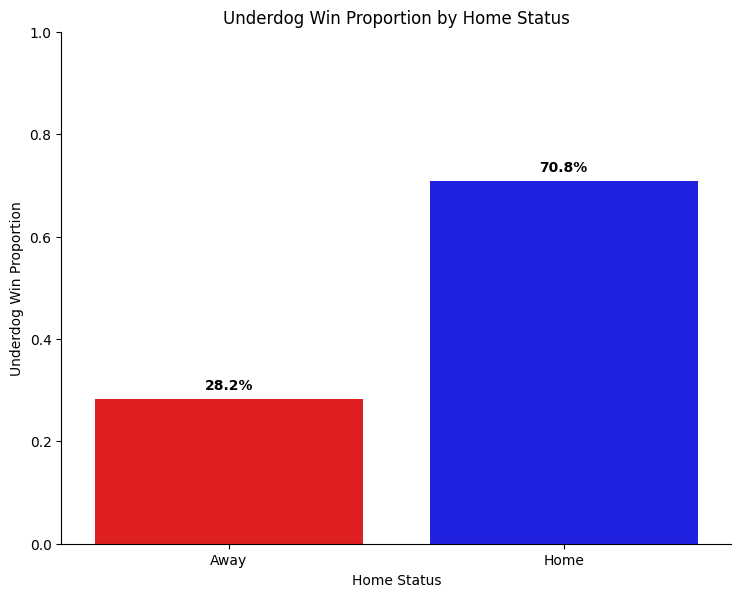

In [23]:
# Reset the index
upset_summary_dog = upset_summary_dog.reset_index()
# Create the bar plot
upset_summary_dog['home_status'] = upset_summary_dog['is_home'].map({True: 'Home', False: 'Away'})
plt.figure(figsize = (5,4))
g = sns.catplot(
        data=upset_summary_dog,
        x='home_status',
        y='prop',
        kind='bar',
        hue='home_status',
        palette=('red', 'blue')
)
g.figure.set_size_inches(8, 6)
ax = g.ax

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + .02,
        f'{height:.1%}',
        ha='center',
        fontweight='bold'
    )
    
# Label the bar plot
ax.set_xlabel('Home Status')
ax.set_ylabel("Underdog Win Proportion")
ax.set_title("Underdog Win Proportion by Home Status")
ax.set_ylim(0, 1)
plt.show()

/var/folders/2t/0j9q5vjs2_l2pp_7wflhtr3w0000gn/T/ipykernel_62237/3658188030.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


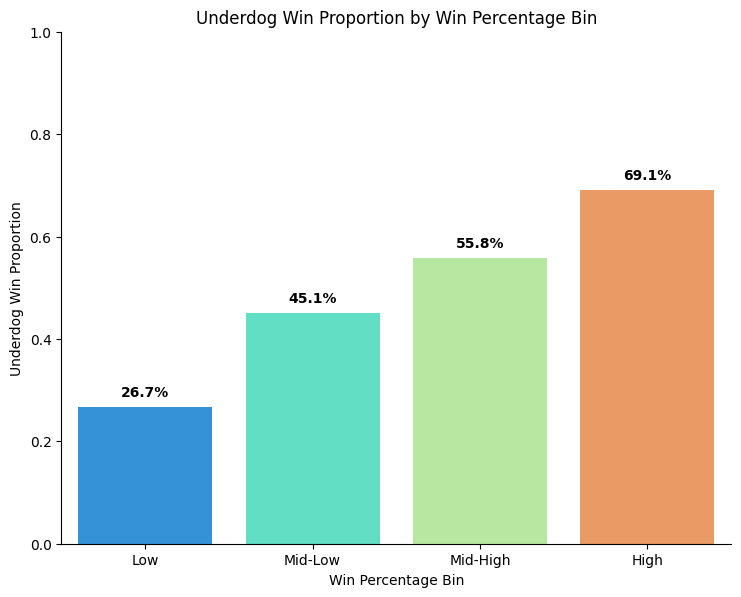

In [24]:
# Reset the index
w_pct_upset_summary = w_pct_upset_summary.reset_index()
# Create the bar plot
g = sns.catplot(
        data=w_pct_upset_summary,
        x='w_pct_bin', 
        y='prop',
        kind='bar',
        palette='rainbow'
)

g.figure.set_size_inches(8, 6)
ax = g.ax

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + .02,
        f'{height:.1%}',
        ha='center',
        fontweight='bold'
    )
    
# Label the bar plot
ax.set_xlabel("Win Percentage Bin")
ax.set_ylabel("Underdog Win Proportion")
ax.set_title("Underdog Win Proportion by Win Percentage Bin")
ax.set_ylim(0, 1)
plt.show()

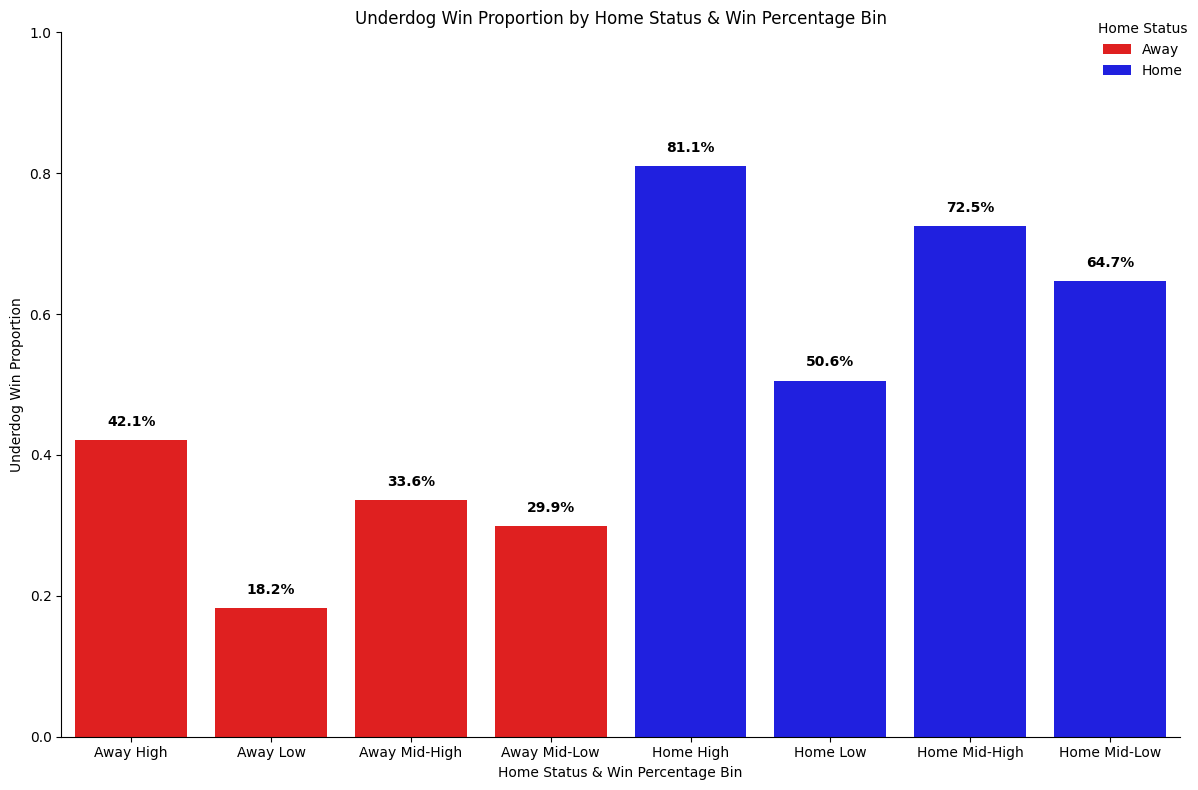

In [25]:
# Reset the index
upset_summary = upset_summary.reset_index()
# Extract "Home" or "Away" from the `home_w_pct_bin` column
upset_summary['home_status'] = upset_summary['home_w_pct_bin'].apply(lambda x: 'Home' if 'Home' in x else 'Away')
# Create the bar plot
g = sns.catplot(
        data=upset_summary, 
        x='home_w_pct_bin', 
        y='prop', 
        kind='bar',
        hue='home_status', 
        palette={'Home': 'blue', 'Away': 'red'}
)

g.figure.set_size_inches(12, 8)
ax = g.ax

for p in ax.patches:
    height = p.get_height()
    if height > .01:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + .02,
            f'{height:.1%}',
            ha='center',
            fontweight='bold'
        )

# Label the bar plot
ax.set_xlabel("Home Status & Win Percentage Bin")
ax.set_ylabel("Underdog Win Proportion")
ax.set_title("Underdog Win Proportion by Home Status & Win Percentage Bin")
ax.set_ylim(0, 1)
g._legend.set_title("Home Status")
g._legend.set_bbox_to_anchor((1, .925))
plt.tight_layout()
plt.show()

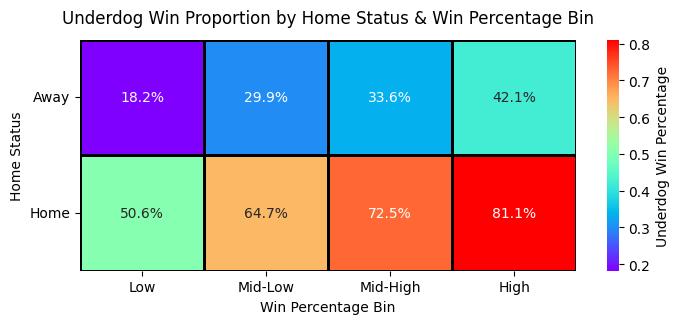

In [38]:
# Extract bin level from 'home_w_pct_bin' (removes Home/Away prefix)
upset_summary['w_pct_bin'] = (
    upset_summary['home_w_pct_bin']
    .str.extract(r'(Low|Mid-Low|Mid-High|High)')[0]
)
# Optional: define order for consistent display
bin_order = ['Low', 'Mid-Low', 'Mid-High', 'High']

# Pivot: Home/Away on y-axis, Win% bins on x-axis
heat = (
    upset_summary
    .pivot(index='home_status', columns='w_pct_bin', values='prop')
    .reindex(index=['Away', 'Home'], columns=bin_order)
)

# Plot heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(
    heat,
    annot=True,
    fmt=".1%",
    cmap='rainbow',
    linecolor='black',
    linewidths=.75,
    cbar_kws={'label': 'Underdog Win Percentage'}
)

# Labels and formatting
plt.title("Underdog Win Proportion by Home Status & Win Percentage Bin", pad=12)
plt.xlabel("Win Percentage Bin")
plt.ylabel("Home Status")
plt.yticks(rotation=0)
plt.show()
